In [1]:
import numpy as np
import pandas as pd
import math
from matplotlib import pyplot as plt
from numpy import array
import tensorflow as tf
import pickle
import keras
from keras.utils.vis_utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import concatenate
from keras.layers.recurrent import LSTM,GRU
from sklearn.model_selection import TimeSeriesSplit
import time
import itertools
import os
import warnings
import io
import inspect
import random 
from random import randrange
import datetime
from datetime import datetime
from random import randrange
from tensorflow.keras.optimizers import Adam
from time import sleep
from tqdm import tqdm
warnings.filterwarnings('ignore')

In [ ]:
# quater hour steps
list_features_noWeather = ['time of day_0.0', 'time of day_0.25', 'time of day_0.5', 'time of day_0.75', 'time of day_1.0', 'time of day_1.25', 'time of day_1.5', 'time of day_1.75', 'time of day_2.0', 'time of day_2.25', 'time of day_2.5', 'time of day_2.75', 'time of day_3.0', 'time of day_3.25', 'time of day_3.5', 'time of day_3.75', 'time of day_4.0', 'time of day_4.25', 'time of day_4.5', 'time of day_4.75', 'time of day_5.0', 'time of day_5.25', 'time of day_5.5', 'time of day_5.75', 'time of day_6.0', 'time of day_6.25', 'time of day_6.5', 'time of day_6.75', 'time of day_7.0', 'time of day_7.25', 'time of day_7.5', 'time of day_7.75', 'time of day_8.0', 'time of day_8.25', 'time of day_8.5', 'time of day_8.75', 'time of day_9.0', 'time of day_9.25', 'time of day_9.5', 'time of day_9.75', 'time of day_10.0', 'time of day_10.25', 'time of day_10.5', 'time of day_10.75', 'time of day_11.0', 'time of day_11.25', 'time of day_11.5', 'time of day_11.75', 'time of day_12.0', 'time of day_12.25', 'time of day_12.5', 'time of day_12.75', 'time of day_13.0', 'time of day_13.25', 'time of day_13.5', 'time of day_13.75', 'time of day_14.0', 'time of day_14.25', 'time of day_14.5', 'time of day_14.75', 'time of day_15.0', 'time of day_15.25', 'time of day_15.5', 'time of day_15.75', 'time of day_16.0', 'time of day_16.25', 'time of day_16.5', 'time of day_16.75', 'time of day_17.0', 'time of day_17.25', 'time of day_17.5', 'time of day_17.75', 'time of day_18.0', 'time of day_18.25', 'time of day_18.5', 'time of day_18.75', 'time of day_19.0', 'time of day_19.25', 'time of day_19.5', 'time of day_19.75', 'time of day_20.0', 'time of day_20.25', 'time of day_20.5', 'time of day_20.75', 'time of day_21.0', 'time of day_21.25', 'time of day_21.5', 'time of day_21.75', 'time of day_22.0', 'time of day_22.25', 'time of day_22.5', 'time of day_22.75', 'time of day_23.0', 'time of day_23.25', 'time of day_23.5', 'time of day_23.75', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weekday_7'] 


def normalize(df, column_list):
    result = df.copy()
    # encoding 'time of the day' and 'weekday' to dummies
    result = pd.get_dummies(result, columns = ['time of day', 'weekday'])
    for feature_name in column_list:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result


def split_sequence(sequence, n_steps_in, n_steps_out):
    """
    split time series to X and y with predefined n_steps_in, n_steps_out
    for example n_steps_in = 336, n_steps_out = 1 use 336 time points to generate 1-hour-ahead prediction
    ----------
    Parameters:
    sequence : time series
    n_steps_in: length of historical net load input in hours
    n_steps_out: length of net load prediction horizon in hours
    ----------
    return: Input sequence X as array, y sequence as array 
    """
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of the sequence
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are out of range
        if out_end_ix+1 > len(sequence):
            break
        # define input and output sequence
        seq_x, seq_y = sequence[i:end_ix], sequence[out_end_ix:out_end_ix+1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)


def pinball_loss(q, y, f):
    """
    define loss function
    ----------
    Parameters:
    q: quantile
    y: real observation
    f: forecast
    ----------
    return: loss function 
    """
    e = (y-f)
    return keras.backend.mean(keras.backend.maximum(q*e, (q-1)*e), axis=-1)


def run_model(input_data, n_train, n_steps_in, n_steps_out, weather_included, method, learning_rate, n_unit, n_Dense_unit, n_batch_size, 
              n_epochs, n_test):
    """
    This function first builds the model, trains the model and then tests the model
    ----------
    Parameters:
    input_data: input_data
    n_train: length of training set
    n_steps_in: length of historical net load input in hours
    n_steps_out: length of net load prediction horizon in hours
    weather_included: Boolean indicating whether weather data are to be taken into account 
    method: desired prediction method (GRU, LSTM, Regression)
    n_test: length of test set

    hyperparameters:
    learning_rate: learning rate
    n_unit: amount of neurons in recurrent hidden layers
    n_Dense_unit: amount of neurons in dense hidden layers
    n_batch_size: batch size
    n_epochs: epochs
    
    ----------
    return: 
    yhat: forecast
    train_loss: loss on train set
    test_loss: loss on test set
    train_time: time needed for model training
    """
    
    if weather_included == 1:
        X2_feature_list = list_features_withWeather
    else:
        X2_feature_list = list_features_noWeather
    
    # Set X1_train, X2_train, and y_train
    X1_seq = input_data['net_consumption'].values.flatten().tolist()[0:n_train]
    X1_train, y_train =  split_sequence(X1_seq, n_steps_in, n_steps_out)
    X1_train = X1_train.reshape((X1_train.shape[0], X1_train.shape[1], 1))
    X2_train = input_data[X2_feature_list][(n_steps_in + n_steps_out):n_train].values.flatten()
    X2_train = X2_train.reshape((X1_train.shape[0], len(X2_feature_list)))
    
    # build model according to figure 8 in the paper
    if method == "LSTM":
        input1 = Input(shape=(n_steps_in, 1))
        input2 = Input(shape=(len(X2_feature_list),))
        recurrent_hidden1 = LSTM(n_unit, activation='sigmoid', return_sequences=True, bias_regularizer='l2')(input1)
        recurrent_hidden2 = LSTM(n_unit, activation='relu', bias_regularizer='l2')(recurrent_hidden1)
        recurrent_output = Dense(1, activation='relu')(recurrent_hidden2) 
        merge = keras.layers.concatenate([recurrent_output, input2])
        hidden1 = Dense(n_Dense_unit, activation='relu', bias_regularizer='l2')(merge)
        hidden_last = Dense(n_Dense_unit, activation='relu', bias_regularizer='l2')(hidden1)  

    output_25 = Dense(1, activation='sigmoid', name='output_25')(hidden_last)
    output_50 = Dense(1, activation='sigmoid', name='output_50')(hidden_last)
    output_75 = Dense(1, activation='sigmoid', name='output_75')(hidden_last)
    output_90 = Dense(1, activation='sigmoid', name='output_90')(hidden_last)
    output_95 = Dense(1, activation='sigmoid', name='output_95')(hidden_last)
    model = Model(inputs=[input1, input2], outputs=[output_25, output_50, output_75, output_90, output_95])
 
    optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate, beta_1=0.9,
      beta_2=0.999, epsilon=1e-07,clipvalue=1.0)
    
    
    model.compile(loss={'output_25': lambda y,f: pinball_loss(0.25,y,f),
                        'output_50': lambda y,f: pinball_loss(0.50,y,f),
                        'output_75': lambda y,f: pinball_loss(0.75,y,f),
                        'output_90': lambda y,f: pinball_loss(0.90,y,f),
                        'output_95': lambda y,f: pinball_loss(0.95,y,f)},
                  optimizer=optimizer)

    # fit model
    start = time.time()
    history = model.fit([X1_train, X2_train], [y_train, y_train, y_train, y_train, y_train], epochs=n_epochs,  batch_size=n_batch_size, shuffle=False)


    print("fit complete!")
    end = time.time()
    train_time = end - start
    print("train_time is: " + str(train_time) + " seconds") 
    
    train_loss = model.evaluate([X1_train, X2_train], [y_train, y_train, y_train, y_train, y_train])
    print("train_loss is: " + str(train_loss))
    
    # test model
    n_total = input_data.shape[0]
    X1_test_seq = input_data['net_consumption'].values.flatten().tolist()[n_train - n_steps_in - n_steps_out:n_test]
    X1_test, y_test =  split_sequence(X1_test_seq, n_steps_in, n_steps_out)
    X1_test = X1_test.reshape((X1_test.shape[0], X1_test.shape[1], 1)) #X1_test = X1_test.reshape((X1_test.shape[0], X1_test.shape[1], 1)) (28048, 168, 1)
    X2_test = input_data[X2_feature_list][n_train:n_test].values.flatten() 
    X2_test = X2_test.reshape((X1_test.shape[0], len(X2_feature_list)))
    yhat = model.predict([X1_test, X2_test])
    test_loss = model.evaluate([X1_test, X2_test], [y_test, y_test, y_test, y_test, y_test])
    print("test_loss is: " + str(test_loss))
    return yhat, train_loss, test_loss, train_time


def summarize_result(yhat, id, method, weather_included, n_test, learning_rate, n_Dense_unit, n_unit):
    """
    summarize forecast and corresponding loss 
    ----------
    Parameters:
    yhat: forecast
    id: Household id 
    method: desired forecast method (GRU, LSTM, Regression)
    weather_included: Boolean indicating whether weather data are to be taken into account
    n_test: length of test set

    learning_rate: learning rate
    n_Dense_unit: amount of neurons in dense hidden layers
    n_unit: amount of neurons in recurrent hidden layers
    ----------
    return: 
    result_yhat: forecast
    result_loss: forecast loss
    """
    columns_list = ['id', 'method', 'weather_included', 'quantile', 'train_loss', 'test_loss', 'learning_rate', 'n_Dense_unit', 'n_unit']+ list(range(1, n_test-n_train+1))
    result_yhat = pd.DataFrame(columns=columns_list)
    q = ['25%', '50%', '75%', '90%', '95%'] #['50%', '75%', '90%', '95%', '99%']
    for i in range(0,5): #for i in range(0,5):
        result_list = [id, method, weather_included, q[i], yhat[1][i+1], yhat[2][i+1], learning_rate, n_Dense_unit, n_unit] + yhat[0][i].flatten().tolist()
        result = pd.DataFrame([result_list],columns=columns_list)
        result_yhat= result_yhat.append(result)
        
    columns_list = ['id', 'method', 'weather_included', 'time', 'train_loss', 'test_loss', 'learning_rate', 'n_Dense_unit', 'n_unit']
    result_loss = pd.DataFrame(columns=columns_list)
    result_list = [id, method, weather_included, yhat[3], yhat[1][0], yhat[2][0], learning_rate, n_Dense_unit, n_unit]
    result = pd.DataFrame([result_list],columns=columns_list)
    result_loss= result_loss.append(result)
    return result_yhat, result_loss


def forecast(input_data, id, n_steps_out, n_total, n_train, n_steps_in, n_test, hyper_params, path):
    """
    Performes forecasting, saves results and returns a list of forecast results and list of corresponding losses
    ----------
    Parameters:
    input_data: input_data
    id: Household ids
    n_steps_out: length of net load prediction horizon in hours
    n_total: length of total data set 
    n_train: length of training set
    n_steps_in: length of historical net load input in hours
    n_test: length of test set
    hyper_params: set of hyperparameters
    path: output path
    ----------
    return: 
    yhat_list: list of forecast results
    loss_list: list of corresponding losses 
    """
    input_data = input_data.loc[input_data['id'] == id].head(n_total)
    yhat_list = pd.DataFrame()
    loss_list = pd.DataFrame()
    for method, weather_included, learning_rate, n_Dense_unit, n_unit in hyper_params:
        print ("learning_rate, n_unit, n_Dense_unit: ", learning_rate, n_unit, n_Dense_unit)
        yhat = run_model(input_data, n_train, n_steps_in, n_steps_out, weather_included, method, learning_rate, n_unit, n_Dense_unit, n_batch_size, n_epochs, n_test)
        yhat, loss = summarize_result(yhat, id, method, weather_included, n_test, learning_rate, n_Dense_unit, n_unit)
        yhat_list = yhat_list.append(yhat)
        loss_list = loss_list.append(loss)
        print('\n')
    yhat_list.to_pickle(path+'/yhat_net_'+str(id)+'_'+method+'_'+str(weather_included))
    loss_list.to_pickle(path+'/loss_net_'+str(id)+'_'+method+'_'+str(weather_included))
    return yhat_list, loss_list

In [ ]:
# Original Read in data for v1_Uxx.pkl
input_data = pd.read_pickle(r"__path__") #(r"C:\Users\Jonas\Dropbox\Mein PC (PCJonas)\Desktop\uni\SGA\untouched\Gesamtverbrauchsdaten_TU.csv", sep=";")
id_list = input_data['id'].unique()
id_list = id_list.tolist() # a list with the ids of all (40) houses
id_list = id_list
input_data = normalize(input_data, ['net_consumption'])
input_data

In [ ]:
## Data set split
#number of total observations
n_total = len(input_data.index.unique()) 
# number of observations used for training
n_train = int(round(n_total * 0.25, 0)) 
# number of observations used for testing
n_test = int(n_train + round(n_total * 0.25, 0))
print('n_total, n_train, n_test: ',n_total, n_train, n_test)


## Sliding window
# length of historical net load input in hours
n_steps_in = 1344 # // 1344 = 14 days
# length of net load prediction horizon in hours
n_steps_out = 96 # // 96 = 1 day


##Modelparameters
method = 'LSTM' 
weather_included = 0 


##hyperparameters that are not tuned 
n_epochs = 10
n_batch_size = 2880 

##Hyperparameters to tune
hyper_params = [(method, weather_included, 0.001, 10, 4), (method, weather_included, 0.001, 10, 8), (method, weather_included, 0.001, 10, 12),
                (method, weather_included, 0.001, 30, 4), (method, weather_included, 0.001, 30, 8), (method, weather_included, 0.001, 30, 12),
                (method, weather_included, 0.001, 50, 4), (method, weather_included, 0.001, 50, 8), (method, weather_included, 0.001, 50, 12),
                (method, weather_included, 0.01, 10, 4), (method, weather_included, 0.01, 10, 8), (method, weather_included, 0.01, 10, 12),
                (method, weather_included, 0.01, 30, 4), (method, weather_included, 0.01, 30, 8), (method, weather_included, 0.01, 30, 12),
                (method, weather_included, 0.01, 50, 4), (method, weather_included, 0.01, 50, 8), (method, weather_included, 0.01, 50, 12),
                (method, weather_included, 0.1, 10, 4), (method, weather_included, 0.1, 10, 8), (method, weather_included, 0.1, 10, 12),
                (method, weather_included, 0.1, 30, 4), (method, weather_included, 0.1, 30, 8), (method, weather_included, 0.1, 30, 12),
                (method, weather_included, 0.1, 50, 4), (method, weather_included, 0.1, 50, 8), 
                (method, weather_included, 0.1, 50, 12)
                ]




path = r"__path__"#'/content' #Set output path  

for i in [7,8,9,10,24]: #id_list:
    print('id: ', i)
    locals()['yhat_net_'+str(i)], locals()['yloss_net_'+str(i)] =  forecast(input_data, i , n_steps_out, n_total, n_train, n_steps_in, n_test, hyper_params, path)

In [ ]:
# read in validation results and identify hyper parameter combination with lowest loss
path =  (r"__path__") #set input path

data=[]
for i, file in enumerate(os.listdir(path)):
    if file.startswith('loss'):
        output_file = pd.read_pickle(os.path.join(path,file))
        index=pd.Series(range(0,len(output_file)))
        output_file=output_file.set_index(index)
        min_idx=output_file['test_loss'].idxmin()
        data.append(output_file.iloc[min_idx,])

df_min_test_loss = pd.DataFrame(data)
df_min_test_loss.to_pickle(fr"__path__") #set output path

In [ ]:
## Data set split
#number of total observations
n_total = len(input_data.index.unique()) 
# number of observations used for training
n_train = int(round(n_total * 0.5, 0))+1
# number of observations used for testing
n_test = n_total # set accordingly 

## Sliding window
# length of historical net load input in hours
n_steps_in = 1344 # // 1344 = 14 days
# length of net load prediction horizon in hours
n_steps_out = 96 # // 96 = 1 day


##Modelparameters
method = 'LSTM' 
weather_included = 0 


##hyperparameters that are not tuned 
n_epochs = 10
n_batch_size = 2880 


path = r"__path__" # set output path

method = 'LSTM' # GRU, LSTM, Regression
weather_included = 0 # 1: withWeather, 0: withoutWeather

for i in [8]:
    print('id: ', i)
    df_min_test_loss = pd.read_pickle(r"__path__") # set input path to min Test Loss Parameters
    df_min_test_loss = df_min_test_loss[df_min_test_loss['id'] == i]
    learning_rate = float(df_min_test_loss['learning_rate'])
    n_Dense_unit = int(df_min_test_loss['n_Dense_unit'])
    n_unit = int(df_min_test_loss['n_unit'])
    hyper_params = [(method, weather_included, learning_rate, n_Dense_unit, n_unit)]
    print('Optimal hyperparams: ', hyper_params)
    locals()['yhat_net_'+str(i)], locals()['yloss_net_'+str(i)] =  forecast(input_data, i , n_steps_out, n_total, n_train, n_steps_in, n_test, hyper_params, path)

In [4]:
def get_orgscale(id):
    ## Data set split
    #number of total observations
    n_total = len(input_data.index.unique()) 
    # number of observations used for training
    n_train = int(round(n_total * 0.5, 0))+1 
    # number of observations used for testing
    n_test = n_total 
    print('n_total, n_train, n_test: ',n_total, n_train, n_test)
    
    # read in normalized output
    pickle = pd.read_pickle(fr"__path__\yhat_net_{id}_LSTM_0")#pickle = pd.read_pickle(fr"C:\Users\Jonas\Dateien\univ\risikolevel\data\quater_hour\output\tested\U_10_7_8_9_24\yhat_net_{id}_LSTM_0")
    yhat1_org = input_data[input_data['id'] == id]                                   
    yhat1_org = yhat1_org.iloc[yhat1_org.shape[0]-(n_test-n_train):yhat1_org.shape[0],0:1]    
    yhat1 = pickle.iloc[:,9:pickle.shape[1]].T                
    yhat1.columns = ['25%', '50%','75%','90%','95%']
    fc1 = yhat1_org.copy()
    fc1['25%'] = ''
    fc1['50%'] = ''
    fc1['75%'] = ''
    fc1['90%'] = ''
    fc1['95%'] = ''
    print(fc1.shape, yhat1.shape)
    for i in range(fc1.shape[0]):                                                   # merge net_consumption and quantiles together in one dataframe (fc1)
        fc1.iloc[i,1] = yhat1.iloc[i,0]
        fc1.iloc[i,2] = yhat1.iloc[i,1]
        fc1.iloc[i,3] = yhat1.iloc[i,2]
        fc1.iloc[i,4] = yhat1.iloc[i,3]
        fc1.iloc[i,5] = yhat1.iloc[i,4]
    fc1.drop(fc1.tail(1).index,inplace=True)
    
    
    # bring to original scale
    data_v8 = pd.read_pickle(fr"__path__\U_10_7_8_9_24.pkl")
    max_v8 = data_v8['net_consumption'].max()
    min_v8 = data_v8['net_consumption'].min()
    fc1_orgscale = fc1.copy()
    for i in range(fc1_orgscale.shape[0]):
        fc1_orgscale.iloc[i,0] = fc1_orgscale.iloc[i,0] * (max_v8 - min_v8) + min_v8
        fc1_orgscale.iloc[i,1] = fc1_orgscale.iloc[i,1] * (max_v8 - min_v8) + min_v8
        fc1_orgscale.iloc[i,2] = fc1_orgscale.iloc[i,2] * (max_v8 - min_v8) + min_v8
        fc1_orgscale.iloc[i,3] = fc1_orgscale.iloc[i,3] * (max_v8 - min_v8) + min_v8
        fc1_orgscale.iloc[i,4] = fc1_orgscale.iloc[i,4] * (max_v8 - min_v8) + min_v8
        fc1_orgscale.iloc[i,5] = fc1_orgscale.iloc[i,5] * (max_v8 - min_v8) + min_v8
    return fc1_orgscale


def show_date(original, start_date, stop_date):
    yhat1_show = original.loc[start_date:stop_date,:] 
    fig = plt.figure()
    yhat1_show.plot(figsize=(15,10));                                              
    fig.suptitle('Percentiles and actual consumption')
    plt.yscale('linear')
    plt.xlabel('Time [h]')
    plt.ylabel('Consumption [kW]')
    return fig



<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

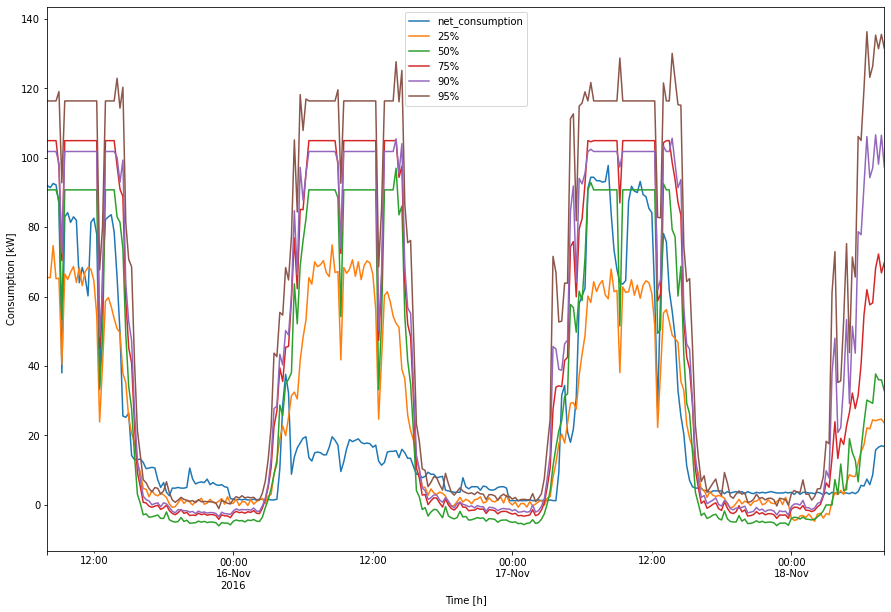

In [5]:
show_date(yfc_7, '2016-11-15 08:00:00', '2016-11-18 08:00:00')

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

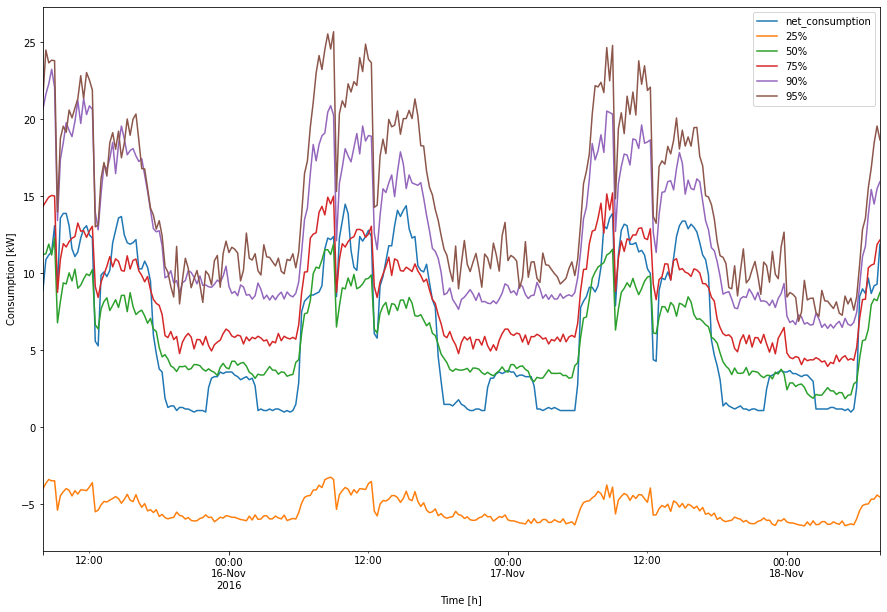

In [6]:
show_date(yfc_8, '2016-11-15 08:00:00', '2016-11-18 08:00:00')

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

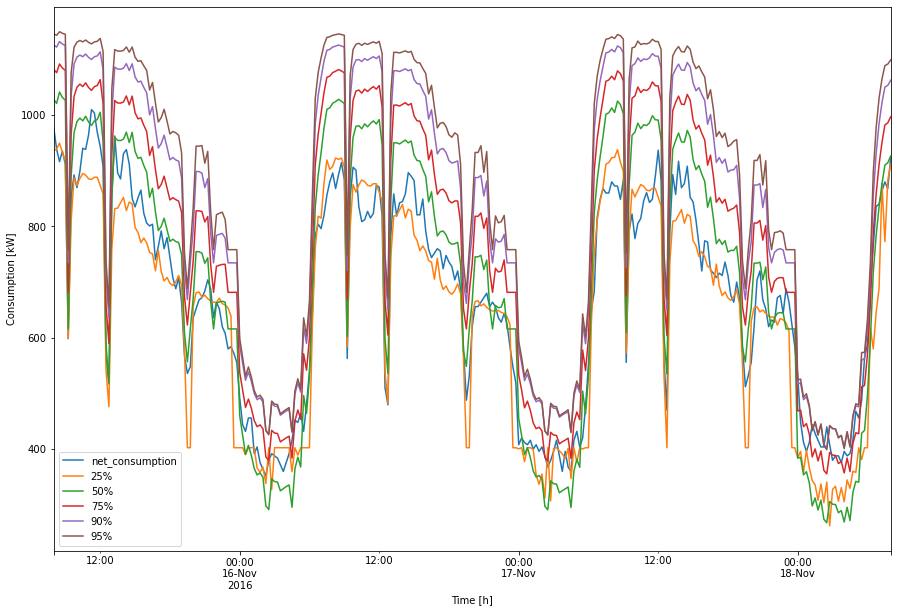

In [7]:
show_date(yfc_9, '2016-11-15 08:00:00', '2016-11-18 08:00:00')

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

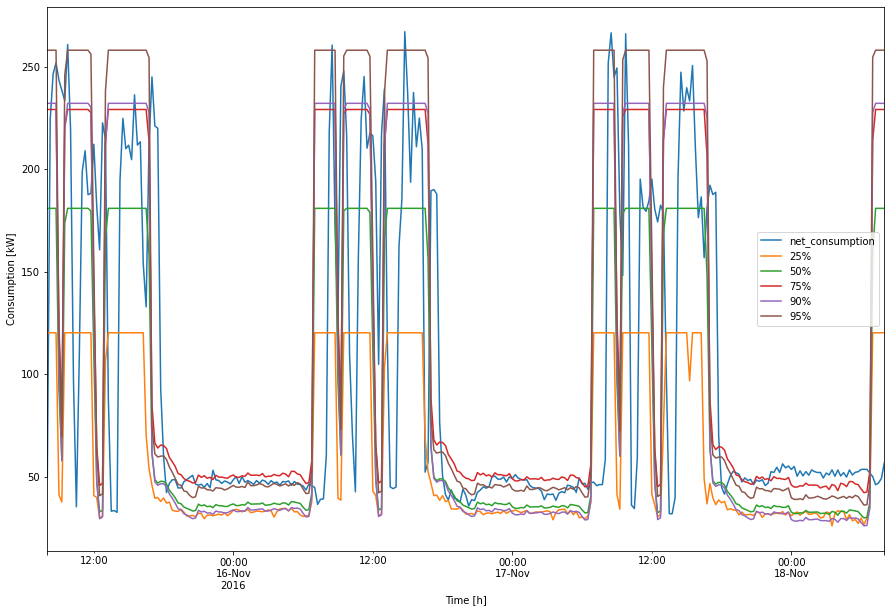

In [8]:
show_date(yfc_10, '2016-11-15 08:00:00', '2016-11-18 08:00:00')

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

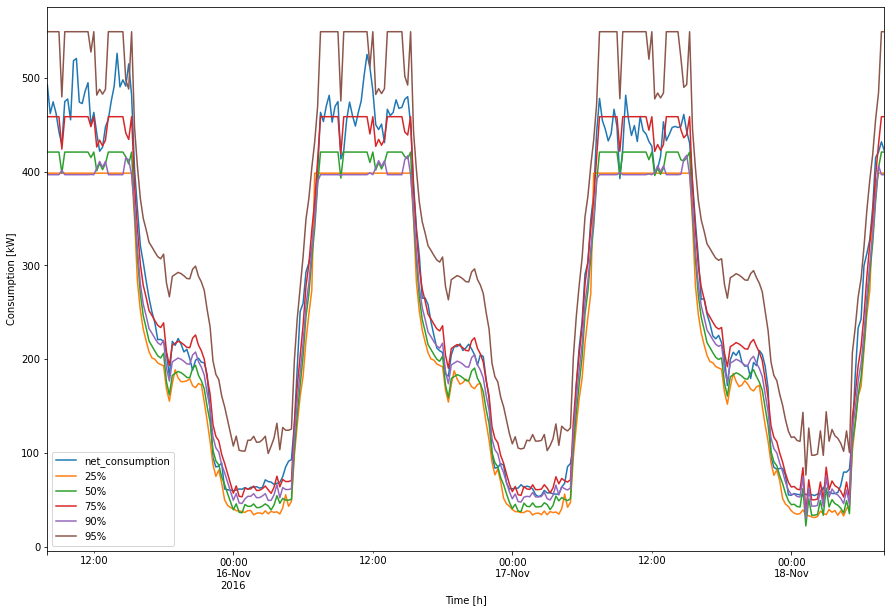

In [9]:
show_date(yfc_24, '2016-11-15 08:00:00', '2016-11-18 08:00:00')